Reinforcement learning avec réseaux de neuronnes 

Paramètres

In [1]:
total_episodes = 100000         # Total episodes
# learning_rate = 0.8           # Learning rate
max_steps = 99                # Max steps per episode
gamma = 0.95                  # Discounting rate

# Exploration parameters
epsilon = 1                 # Exploration rate # au début explore 

max_epsilon = 0.99             # Exploration probability at start # 5% d'exploration
min_epsilon = 0.01            # Minimum exploration probabilit
# decay_rate = 0.005             # Exponential decay rate for exploration prob 
decay_rate = 0.0001

load_weight = True
save_weight = True 

### Import des librairies 

Utile pour l'environnement

In [2]:
import numpy as np
import gym
import tensorflow as tf
import random

Utile pour l'affichage graphique 

In [17]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym[classic_control]

import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Création de l'environnement

- le FrozenLake-V0 est depreceated pour la version de gym utilisé
- l'option "is_slippery" autorise le déplacement diagonal
- l'option "map_name" permet de choisir entre deux version "4x4" ou "8x8" 

In [4]:
desc1=["SFFF", 
       "FGFH", 
       "FFFH", 
       "HFFH"]
  
desc2=["SFFF", 
       "FFFH", 
       "FFGH", 
       "HFFH"]

In [5]:
# env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=False)
# env = gym.make("FrozenLake-v1", render_mode = "ansi", is_slippery=False)
env = gym.make("FrozenLake-v1", is_slippery=False)

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


On veut connaitre nb_etats et nb_actions, qui seront respectivement le nombre d'input du réseau de neuronne et le nombre d'output du réseau de neuronne 

In [6]:
nb_actions = env.action_space.n
nb_etats = env.observation_space.n

### Création du réseau de neuronne 

Caractéristiques du réseau de neuronne :
- tf_input_size : nombre d'entrée dans la couche input du réseau 
- tf_hidden_size : nombre de neuronne dans la couche hidden du réseau
- tf_output_size : nombre de neuronne dans la couhe sortie du réseau 


In [7]:
tf_input_size = nb_etats
tf_output_size = nb_actions
tf_hidden_size = (tf_input_size+tf_output_size)//2
# tf_hidden_size = int(2/3*tf_input_size+tf_output_size)

In [8]:
tf.compat.v1.reset_default_graph() # pour supprimer les variables tensorflow d'avant
tf.compat.v1.disable_eager_execution() # nécessaire pour utiliser compat.v1

In [9]:
# Placeholder du réseau
tf_inputs = tf.compat.v1.placeholder(tf.float32, [None, tf_input_size]) # (1x16)
tf_next_q = tf.compat.v1.placeholder(tf.float32, [None, tf_output_size]) # (1x4)

weight_initer = tf.compat.v1.truncated_normal_initializer(mean=.00, stddev=20)
biases_initer = tf.compat.v1.truncated_normal_initializer(mean=5, stddev=20)


# Hidden Layers (16x10) (10)
# tf.compat.v1.zeros_initializer
tf_weights_1 = tf.compat.v1.get_variable("tf_weights_1", [tf_input_size, tf_hidden_size], initializer = weight_initer)
tf_biases_1 = tf.compat.v1.get_variable("tf_biases_1", [tf_hidden_size], initializer=biases_initer)
tf_outputs_1 = tf.nn.relu(tf.matmul(tf_inputs, tf_weights_1) + tf_biases_1)
# tf_outputs_1 = tf.matmul(tf_inputs, tf_weights_1) + tf_biases_1

# Output (10x4) (4)
tf_weights_out = tf.compat.v1.get_variable("tf_weights_out", [tf_hidden_size, tf_output_size], initializer=weight_initer)
tf_biases_out = tf.compat.v1.get_variable("tf_biases_out", [tf_output_size], initializer=biases_initer)
tf_outputs = tf.matmul(tf_outputs_1, tf_weights_out) + tf_biases_out
# tf_outputs = tf.sigmoid(tf.matmul(tf_outputs_1, tf_weights_out) + tf_biases_out)

# Fonctions
tf_action = tf.argmax(input=tf_outputs, axis=1)
tf_loss = tf.reduce_sum(input_tensor=tf.square(tf_outputs - tf_next_q))
# tf_optimize = tf.compat.v1.train.GradientDescentOptimizer(learning_rate=0.001).minimize(tf_loss)
tf_optimize = tf.compat.v1.train.AdamOptimizer(learning_rate=0.0001).minimize(tf_loss)

Pour faire fonctionner le réseau, on peut utiliser les sessions de tensorflow. <br>
Les fonctions utilisables sont :
- tf_outputs : (feed : tf_inputs) 
- tf_action : (feed : tf_inputs) pour obtenir le meilleur tf_action possible
- tf_loss : (feed : tf_inputs, tf_next_q) pour calculer la différence entre les outputs calculés par le réseau et les outputs idéals (donnée par le q_learning)
- tf_optimize : (feed : tf_outputs, tf_next_q) appel le tf_loss pour changer les poids afin de minimaliser le loss 

Poids à l'initialisation

In [10]:
sess = tf.compat.v1.InteractiveSession()
initializer = tf.compat.v1.global_variables_initializer()
sess.run(initializer)

In [11]:
import sys 
print("tf_weights_1", tf_weights_1)
sess.run(tf.print(tf_weights_1, output_stream=sys.stderr))
print("\n")
print("tf_biases_1", tf_biases_1)
sess.run(tf.print(tf_biases_1, output_stream=sys.stderr))
print("\n")
print("tf_weights_out", tf_weights_out)
sess.run(tf.print(tf_weights_out, output_stream=sys.stderr))
print("\n")
print("tf_biases_out", tf_biases_out)
sess.run(tf.print(tf_biases_out, output_stream=sys.stderr))
print("\n")


tf_weights_1 <tf.Variable 'tf_weights_1:0' shape=(16, 10) dtype=float32>
[[25.3245316 -10.0627699 1.60331738 ... 6.13049555 17.5953064 -3.41780686]
 [-10.7427931 4.71914577 -37.3230667 ... -20.9014225 22.788887 -13.171319]
 [7.21668673 7.87504864 -4.9497633 ... 18.4240417 -12.7617416 -2.3762455]
 ...
 [-24.4506664 8.12000084 29.5497856 ... -6.01846457 -5.63198948 -28.8584976]
 [11.8074036 -17.4980526 14.5553741 ... 10.7250156 -5.33129025 25.0850906]
 [-15.3001328 -15.6039095 -17.1677628 ... 4.61163902 -1.82003391 -4.5936389]]


tf_biases_1 <tf.Variable 'tf_biases_1:0' shape=(10,) dtype=float32>
[18.1976299 1.07564592 -14.5878658 ... 21.071661 5.80050278 -28.109127]


tf_weights_out <tf.Variable 'tf_weights_out:0' shape=(10, 4) dtype=float32>
[[-11.3834801 35.9154701 -21.7894936 11.2361441]
 [-10.8576546 -5.60975027 7.02654648 28.348196]
 [0.420029879 -22.8872948 19.4607754 35.0241623]
 ...
 [-2.87644291 -19.927906 -22.2410355 3.55245113]
 [-7.49260807 -24.6009483 -17.355135 -7.84018278

### Entrainement du réseau

[1.0, 0.999901004949835, 0.9997030445455454, 0.9994061781643654, 0.9990104948350413, 0.9985161131933339, 0.9979231814227371, 0.9972318771804541, 0.9964424075086835, 0.995555008731275, 0.99456994633583, 0.9934875148413277, 0.9923080376513693, 0.9910318668931427, 0.9896593832422202, 0.9881909957333113, 0.9866271415571012, 0.9849682858433185, 0.9832149214301807, 0.981367568620378, 0.9794267749237651, 0.9773931147869388, 0.9752671893098889, 0.9730496259499158, 0.9707410782130231, 0.968342225332993, 0.9658537719383689, 0.9632764477075711, 0.9606110070123842, 0.9578582285500573, 0.9550189149642707, 0.9520938924552257, 0.9490840103791229, 0.9459901408373019, 0.9428131782553179, 0.939554038952242, 0.9362136607004747, 0.9327930022763679, 0.9292930430019557, 0.9257147822781039, 0.9220592391093851, 0.9183274516209987, 0.9145204765680534, 0.9106393888375389, 0.9066852809433131, 0.902659262514437, 0.8985624597771925, 0.8943960150311205, 0.8901610861194197, 0.8858588458940488, 0.8814904816758791, 0.

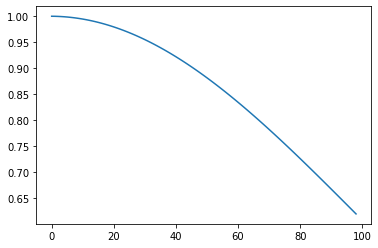

In [12]:
X = []
eps = epsilon
rate = 0.0001
for i in range(99):
  eps = min_epsilon + (eps - min_epsilon)*np.exp(-rate*i)
  X.append(eps)
print(X)
import matplotlib.pyplot as plt
plt.plot(X)

Sauvegarde des poids 

In [13]:
saver = tf.compat.v1.train.Saver()
if load_weight:
    saver.restore(sess, "/content/drive/MyDrive/frozen_lake_weight/")
    print("Model restored.")    

Model restored.


In [ ]:
rewards = []

for episode in range(total_episodes):
    state = env.reset()
    done = False
    total_rewards = 0
    old_state = -10
    # on fait commencer aléatoirement sur la map
    # state = random.randint(0,15)
    ## print("episode {} commence le jeu au state {} ".format(episode, state))
    ## reward = 0
    for step in range(max_steps):
        reward = 0
        # choix de l'action
        exploration = random.uniform(0,1)
        if exploration > epsilon:
            action = sess.run([tf_action], feed_dict={tf_inputs: np.identity(16)[state:state+1]})[0][0]
        else:
            action = env.action_space.sample()
            if state in [2,3]:
              action = random.choice([0,1,2])
            if state in [7,11]:
              action = random.choice([0,1,3])
            if state in [13,14]:
              action = random.choice([0,2,3])
            if state in [4,8]:
              action = random.choice([1,2,3])
            if state == 0:
              action = random.choice([1,2])
            if state == 3:
              action = random.choice([0,1])
            if state == 12:
              action = random.choice([2,3])
            if state == 15:
              action = random.choice([0,3])
            ## print("explore")
        
        

        # on avance   
        # new_state, reward, done, info = env.step(action)
        new_state, _, done, info = env.step(action)
        
        # print("old_state {},new_state {}, action {}".format(state,new_state,action))
        if new_state in [5,7,11,12]:
            reward -= 100000

        if new_state == 15:
            reward += 100
        if old_state == new_state :
            reward -= 100
        # rewarding and updating
        q_vector = sess.run([tf_outputs], feed_dict={tf_inputs: np.identity(16)[state:state+1]})[0][0]
        # print("state {} / q_vector {} / action {}".format(state,q_vector,action))
        q_target = reward + gamma * np.max(q_vector) # correspond en principe à l'action choisie
        q_vector[action] = q_target 
        # print("q_vector {} / q_target {}".format(q_vector,q_target))
        _, loss = sess.run([tf_optimize, tf_loss],
                          feed_dict={tf_inputs: np.identity(16)[state:state+1], 
                                      tf_next_q:q_vector.reshape(1,4)})
        
        old_state = state
        state = new_state
        total_rewards += reward 
        if (step > 97):
            # print("Episode {} finished after {} timesteps, last state : {} and total_rewards {}".format(episode, step+1,state,total_rewards))
            epsilon = min_epsilon + (epsilon - min_epsilon)*np.exp(-decay_rate*episode)
            break
        if done == True:
            # print("Episode {} finished after {} timesteps, last state : {} and total_rewards {}".format(episode, step+1,state,total_rewards))
            epsilon = min_epsilon + (epsilon - min_epsilon)*np.exp(-decay_rate*episode)
            break
    rewards.append(total_rewards)
    # print(total_rewards)
    print("episode {} finished".format(episode))
# print ("Score over time: " +  str(sum(rewards)/total_episodes))

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
episode 83894 finished
episode 83895 finished
episode 83896 finished
episode 83897 finished
episode 83898 finished
episode 83899 finished
episode 83900 finished
episode 83901 finished
episode 83902 finished
episode 83903 finished
episode 83904 finished
episode 83905 finished
episode 83906 finished
episode 83907 finished
episode 83908 finished
episode 83909 finished
episode 83910 finished
episode 83911 finished
episode 83912 finished
episode 83913 finished
episode 83914 finished
episode 83915 finished
episode 83916 finished
episode 83917 finished
episode 83918 finished
episode 83919 finished
episode 83920 finished
episode 83921 finished
episode 83922 finished
episode 83923 finished
episode 83924 finished
episode 83925 finished
episode 83926 finished
episode 83927 finished
episode 83928 finished
episode 83929 finished
episode 83930 finished
episode 83931 finished
episode 83932 finished
episode 83933 finished
ep

In [30]:
if save_weight:
    save_path = saver.save(sess, "/content/drive/MyDrive/frozen_lake_weight/")
    print("Model saved in file: %s" % save_path)

Model saved in file: /content/drive/MyDrive/frozen_lake_weight/


In [ ]:
raise ValueError()

for i in range(16):
  print("Etat {}.             {}".format(i,np.identity(16)[i:i+1][0]))
  print("Sortie tf_weights_1 {}".format(sess.run([tf_outputs_1], feed_dict={tf_inputs: np.identity(16)[i:i+1]})[0][0]))
  print("Sortie tf_outputs   {}".format(sess.run([tf_outputs], feed_dict={tf_inputs: np.identity(16)[i:i+1]})[0][0]))
  print("Sortie tf_action.   {}".format(sess.run([tf_action], feed_dict={tf_inputs: np.identity(16)[i:i+1]})[0][0]))
  print("\n")


In [27]:
tab = np.zeros((4,4))

tab[0][0] = sess.run([tf_action], feed_dict={tf_inputs: np.identity(16)[0:0+1]})[0][0]
tab[0][1] = sess.run([tf_action], feed_dict={tf_inputs: np.identity(16)[1:1+1]})[0][0]
tab[0][2] = sess.run([tf_action], feed_dict={tf_inputs: np.identity(16)[2:2+1]})[0][0]
tab[0][3] = sess.run([tf_action], feed_dict={tf_inputs: np.identity(16)[3:3+1]})[0][0]

tab[1][0] = sess.run([tf_action], feed_dict={tf_inputs: np.identity(16)[4:4+1]})[0][0]
tab[1][1] = sess.run([tf_action], feed_dict={tf_inputs: np.identity(16)[5:5+1]})[0][0]
tab[1][2] = sess.run([tf_action], feed_dict={tf_inputs: np.identity(16)[6:6+1]})[0][0]
tab[1][3] = sess.run([tf_action], feed_dict={tf_inputs: np.identity(16)[7:7+1]})[0][0]

tab[2][0] = sess.run([tf_action], feed_dict={tf_inputs: np.identity(16)[8:8+1]})[0][0]
tab[2][1] = sess.run([tf_action], feed_dict={tf_inputs: np.identity(16)[9:9+1]})[0][0]
tab[2][2] = sess.run([tf_action], feed_dict={tf_inputs: np.identity(16)[10:10+1]})[0][0]
tab[2][3] = sess.run([tf_action], feed_dict={tf_inputs: np.identity(16)[11:11+1]})[0][0]

tab[3][0] = sess.run([tf_action], feed_dict={tf_inputs: np.identity(16)[12:12+1]})[0][0]
tab[3][1] = sess.run([tf_action], feed_dict={tf_inputs: np.identity(16)[13:13+1]})[0][0]
tab[3][2] = sess.run([tf_action], feed_dict={tf_inputs: np.identity(16)[14:14+1]})[0][0]
tab[3][3] = sess.run([tf_action], feed_dict={tf_inputs: np.identity(16)[15:15+1]})[0][0]

print(tab)
print("0: LEFT, 1: DOWN, 2: RIGHT, 3: UP")

[[1. 0. 2. 0.]
 [1. 2. 1. 1.]
 [2. 2. 1. 1.]
 [2. 2. 2. 2.]]
0: LEFT, 1: DOWN, 2: RIGHT, 3: UP


Poids après entrainement et utilisé pendant la phase de test

In [ ]:
print("tf_weights_1", tf_weights_1)
sess.run(tf.print(tf_weights_1, output_stream=sys.stderr))
print("\n")
print("tf_biases_1", tf_biases_1)
sess.run(tf.print(tf_biases_1, output_stream=sys.stderr))
print("\n")
print("tf_weights_out", tf_weights_out)
sess.run(tf.print(tf_weights_out, output_stream=sys.stderr))
print("\n")
print("tf_biases_out", tf_biases_out)
sess.run(tf.print(tf_biases_out, output_stream=sys.stderr))
print("\n")




```
# Ce texte est au format code
```

Affichage graphiqu

KeyboardInterrupt: ignored

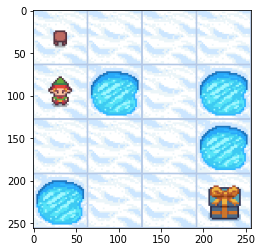

In [29]:
# raise ValueError()
import time 

env = gym.make("FrozenLake-v1",is_slippery=False)
state = env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for episode in range(100):
  env.reset()
  for i in range(50):
    action = sess.run([tf_action], feed_dict={tf_inputs: np.identity(16)[state:state+1]})[0][0]
    print("Episode/Step {} {}".format(episode,i))
    print("State/Next_action {} {}".format(state,action))
    time.sleep(1)
    new_state, reward, done, info = env.step(action)
    screen = env.render(mode='rgb_array')
    
    plt.imshow(screen)
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())
    state = new_state
    if done:
      break
ipythondisplay.clear_output(wait=True)
env.close()

display.stop()